In [1]:
################################################################
#              Aknowledgements                                 #
################################################################
# This notebook takes inspriration from the following work    #
# of kaggle user Black Mamba                                  #
# https://www.kaggle.com/theblackmamba31/who-is-behind-the-mask
#                                                             #
# do upvote her work                                          #
###############################################################


###############################################################
#  This noteBook contains a Transformer for image Segmentation#
###############################################################

In [1]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
tf.__version__

'2.10.0'

In [3]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj
        
    
 
    
   

In [4]:
framObjTrain = LoadData( framObjTrain, imgPath = 'CamVid/train', maskPath = 'CamVid/train_labels'
         , shape = 256)

In [5]:
framObjValidation  = LoadData( framObjValidation, imgPath = 'CamVid/val', maskPath = 'CamVid/val_labels'
         , shape = 256)

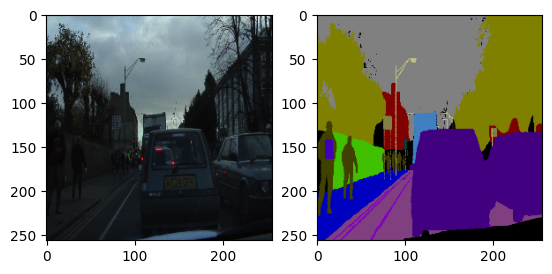

In [6]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [7]:
#convert mask to class
label = pd.read_csv('CamVid/class_dict.csv',usecols=[1,2,3])

rgb_dict = {}
for i in range(32) :
    rgb_dict[ i ] = (label.iloc[i,0],label.iloc[i,1],label.iloc[i,2])
label = label.to_numpy().reshape((32,3))


def RGBtolabel(RGB,label) :
    number = np.linalg.norm(RGB - label,axis=1).argmin()
    return number 
def labeltoRGB(rgb_dict,label) :
    rgb = rgb_dict[label]
    return  np.array( rgb)
    

In [8]:
train_mask_rgb = np.array(framObjTrain['mask'])*255
train_mask_class = np.empty((369,256,256,1))

for k in range(369) : #img #
    for i in range(256) : 
        for j in range(256) : #get rgb pixels
            train_mask_class[k,i,j] = (RGBtolabel(train_mask_rgb[k][i][j],label))
            


: 

In [8]:
val_mask_rgb = np.array(framObjValidation['mask'])*255
val_mask_class = np.empty((100,256,256,1))

for k in range(100) : #img #
    for i in range(256) : 
        for j in range(256) : #get rgb pixels
            val_mask_class[k,i,j] = (RGBtolabel(val_mask_rgb[k][i][j],label))

In [96]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(32, (1, 1), activation = 'softmax')(c9)    
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )

In [97]:
myTransformer.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_415 (Conv2D)            (None, 256, 256, 16  448         ['input_23[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_396 (Batch  (None, 256, 256, 16  64         ['conv2d_415[0][0]']             
 Normalization)                 )                                                          

In [98]:
from tensorflow import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Unet_softmax",
        save_best_only=True,
        monitor="val_loss")
]


In [99]:
## trainign our model
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
retVal = myTransformer.fit(np.array(framObjTrain['img']), train_mask_class, epochs = 150,validation_data=(np.array(framObjValidation['img']),val_mask_class),callbacks=callbacks)

Epoch 1/150
12/12 [==============================] - ETA: 0s - loss: 3.2477 - accuracy: 0.1628INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 19s 1s/step - loss: 3.2477 - accuracy: 0.1628 - val_loss: 19.6874 - val_accuracy: 0.0997
Epoch 2/150
12/12 [==============================] - 6s 454ms/step - loss: 2.7843 - accuracy: 0.4129 - val_loss: 165.5952 - val_accuracy: 0.1009
Epoch 3/150
12/12 [==============================] - 5s 447ms/step - loss: 2.5031 - accuracy: 0.6210 - val_loss: 67.5227 - val_accuracy: 0.1887
Epoch 4/150
12/12 [==============================] - ETA: 0s - loss: 2.2411 - accuracy: 0.6847INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 14s 1s/step - loss: 2.2411 - accuracy: 0.6847 - val_loss: 3.3839 - val_accuracy: 0.3114
Epoch 5/150
12/12 [==============================] - ETA: 0s - loss: 2.0212 - accuracy: 0.7069INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 2.0212 - accuracy: 0.7069 - val_loss: 2.5207 - val_accuracy: 0.3979
Epoch 6/150
12/12 [==============================] - ETA: 0s - loss: 1.8474 - accuracy: 0.7382INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 1.8474 - accuracy: 0.7382 - val_loss: 2.3670 - val_accuracy: 0.5074
Epoch 7/150
12/12 [==============================] - 5s 412ms/step - loss: 1.6985 - accuracy: 0.7540 - val_loss: 2.4077 - val_accuracy: 0.4869
Epoch 8/150
12/12 [==============================] - ETA: 0s - loss: 1.5804 - accuracy: 0.7585INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 14s 1s/step - loss: 1.5804 - accuracy: 0.7585 - val_loss: 2.2263 - val_accuracy: 0.4982
Epoch 9/150
12/12 [==============================] - 6s 461ms/step - loss: 1.4634 - accuracy: 0.7652 - val_loss: 2.4887 - val_accuracy: 0.4094
Epoch 10/150
12/12 [==============================] - 6s 463ms/step - loss: 1.3822 - accuracy: 0.7665 - val_loss: 2.2321 - val_accuracy: 0.4818
Epoch 11/150
12/12 [==============================] - ETA: 0s - loss: 1.2869 - accuracy: 0.7751INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 16s 1s/step - loss: 1.2869 - accuracy: 0.7751 - val_loss: 2.2132 - val_accuracy: 0.4745
Epoch 12/150
12/12 [==============================] - 6s 466ms/step - loss: 1.2064 - accuracy: 0.7821 - val_loss: 2.2604 - val_accuracy: 0.4409
Epoch 13/150
12/12 [==============================] - ETA: 0s - loss: 1.1317 - accuracy: 0.7933INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 1.1317 - accuracy: 0.7933 - val_loss: 2.1383 - val_accuracy: 0.4659
Epoch 14/150
12/12 [==============================] - 6s 461ms/step - loss: 1.0580 - accuracy: 0.8037 - val_loss: 2.1532 - val_accuracy: 0.4554
Epoch 15/150
12/12 [==============================] - 6s 462ms/step - loss: 0.9912 - accuracy: 0.8095 - val_loss: 2.1775 - val_accuracy: 0.4420
Epoch 16/150
12/12 [==============================] - ETA: 0s - loss: 0.9642 - accuracy: 0.8062INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 16s 1s/step - loss: 0.9642 - accuracy: 0.8062 - val_loss: 1.8641 - val_accuracy: 0.5565
Epoch 17/150
12/12 [==============================] - ETA: 0s - loss: 0.9197 - accuracy: 0.8114INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 16s 1s/step - loss: 0.9197 - accuracy: 0.8114 - val_loss: 1.8459 - val_accuracy: 0.5441
Epoch 18/150
12/12 [==============================] - ETA: 0s - loss: 0.8782 - accuracy: 0.8169INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.8782 - accuracy: 0.8169 - val_loss: 1.7770 - val_accuracy: 0.5478
Epoch 19/150
12/12 [==============================] - 6s 458ms/step - loss: 0.8413 - accuracy: 0.8200 - val_loss: 1.7793 - val_accuracy: 0.5453
Epoch 20/150
12/12 [==============================] - ETA: 0s - loss: 0.8128 - accuracy: 0.8225INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 16s 1s/step - loss: 0.8128 - accuracy: 0.8225 - val_loss: 1.7692 - val_accuracy: 0.5586
Epoch 21/150
12/12 [==============================] - ETA: 0s - loss: 0.7906 - accuracy: 0.8252INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 16s 1s/step - loss: 0.7906 - accuracy: 0.8252 - val_loss: 1.5161 - val_accuracy: 0.6338
Epoch 22/150
12/12 [==============================] - ETA: 0s - loss: 0.7703 - accuracy: 0.8274INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 16s 1s/step - loss: 0.7703 - accuracy: 0.8274 - val_loss: 1.4750 - val_accuracy: 0.6283
Epoch 23/150
12/12 [==============================] - 5s 448ms/step - loss: 0.7408 - accuracy: 0.8316 - val_loss: 1.5066 - val_accuracy: 0.6090
Epoch 24/150
12/12 [==============================] - 5s 449ms/step - loss: 0.7236 - accuracy: 0.8337 - val_loss: 1.5098 - val_accuracy: 0.6244
Epoch 25/150
12/12 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.8365INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 16s 1s/step - loss: 0.6995 - accuracy: 0.8365 - val_loss: 1.3925 - val_accuracy: 0.6563
Epoch 26/150
12/12 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.8407INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 16s 1s/step - loss: 0.6774 - accuracy: 0.8407 - val_loss: 1.3686 - val_accuracy: 0.6427
Epoch 27/150
12/12 [==============================] - 6s 463ms/step - loss: 0.6607 - accuracy: 0.8430 - val_loss: 1.4443 - val_accuracy: 0.6217
Epoch 28/150
12/12 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.8439INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 16s 1s/step - loss: 0.6551 - accuracy: 0.8439 - val_loss: 1.1891 - val_accuracy: 0.6904
Epoch 29/150
12/12 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.8440INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.6478 - accuracy: 0.8440 - val_loss: 1.0348 - val_accuracy: 0.7525
Epoch 30/150
12/12 [==============================] - ETA: 0s - loss: 0.6317 - accuracy: 0.8488INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 16s 1s/step - loss: 0.6317 - accuracy: 0.8488 - val_loss: 1.0314 - val_accuracy: 0.7484
Epoch 31/150
12/12 [==============================] - 5s 454ms/step - loss: 0.6112 - accuracy: 0.8532 - val_loss: 1.0804 - val_accuracy: 0.7206
Epoch 32/150
12/12 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.8555INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5989 - accuracy: 0.8555 - val_loss: 1.0088 - val_accuracy: 0.7474
Epoch 33/150
12/12 [==============================] - ETA: 0s - loss: 0.5867 - accuracy: 0.8574INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5867 - accuracy: 0.8574 - val_loss: 0.8907 - val_accuracy: 0.7827
Epoch 34/150
12/12 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.8585INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5799 - accuracy: 0.8585 - val_loss: 0.8762 - val_accuracy: 0.7891
Epoch 35/150
12/12 [==============================] - ETA: 0s - loss: 0.5647 - accuracy: 0.8617INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5647 - accuracy: 0.8617 - val_loss: 0.8514 - val_accuracy: 0.7915
Epoch 36/150
12/12 [==============================] - 6s 455ms/step - loss: 0.5516 - accuracy: 0.8645 - val_loss: 0.9363 - val_accuracy: 0.7530
Epoch 37/150
12/12 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.8654INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5437 - accuracy: 0.8654 - val_loss: 0.8133 - val_accuracy: 0.7993
Epoch 38/150
12/12 [==============================] - ETA: 0s - loss: 0.5318 - accuracy: 0.8680INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5318 - accuracy: 0.8680 - val_loss: 0.7501 - val_accuracy: 0.8220
Epoch 39/150
12/12 [==============================] - 6s 454ms/step - loss: 0.5261 - accuracy: 0.8686 - val_loss: 0.7784 - val_accuracy: 0.8087
Epoch 40/150
12/12 [==============================] - 5s 452ms/step - loss: 0.5138 - accuracy: 0.8716 - val_loss: 0.7867 - val_accuracy: 0.8053
Epoch 41/150
12/12 [==============================] - 5s 451ms/step - loss: 0.5074 - accuracy: 0.8720 - val_loss: 0.7639 - val_accuracy: 0.8098
Epoch 42/150
12/12 [==============================] - 5s 452ms/step - loss: 0.5062 - accuracy: 0.8717 - val_loss: 0.8058 - val_accuracy: 0.7935
Epoch 43/150
12/12 [==============================] - ETA: 0s - loss: 0.5001 - accuracy: 0.8724INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.5001 - accuracy: 0.8724 - val_loss: 0.6947 - val_accuracy: 0.8296
Epoch 44/150
12/12 [==============================] - 6s 452ms/step - loss: 0.4881 - accuracy: 0.8764 - val_loss: 0.7189 - val_accuracy: 0.8190
Epoch 45/150
12/12 [==============================] - ETA: 0s - loss: 0.4814 - accuracy: 0.8777INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4814 - accuracy: 0.8777 - val_loss: 0.6716 - val_accuracy: 0.8349
Epoch 46/150
12/12 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.8781INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4797 - accuracy: 0.8781 - val_loss: 0.6636 - val_accuracy: 0.8357
Epoch 47/150
12/12 [==============================] - 6s 453ms/step - loss: 0.4794 - accuracy: 0.8778 - val_loss: 0.7033 - val_accuracy: 0.8182
Epoch 48/150
12/12 [==============================] - ETA: 0s - loss: 0.4672 - accuracy: 0.8816INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4672 - accuracy: 0.8816 - val_loss: 0.6320 - val_accuracy: 0.8438
Epoch 49/150
12/12 [==============================] - 6s 452ms/step - loss: 0.4604 - accuracy: 0.8836 - val_loss: 0.6457 - val_accuracy: 0.8449
Epoch 50/150
12/12 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.8864INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4510 - accuracy: 0.8864 - val_loss: 0.6211 - val_accuracy: 0.8507
Epoch 51/150
12/12 [==============================] - ETA: 0s - loss: 0.4460 - accuracy: 0.8869INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4460 - accuracy: 0.8869 - val_loss: 0.6008 - val_accuracy: 0.8537
Epoch 52/150
12/12 [==============================] - 6s 452ms/step - loss: 0.4422 - accuracy: 0.8876 - val_loss: 0.6032 - val_accuracy: 0.8543
Epoch 53/150
12/12 [==============================] - 5s 452ms/step - loss: 0.4383 - accuracy: 0.8878 - val_loss: 0.6343 - val_accuracy: 0.8431
Epoch 54/150
12/12 [==============================] - ETA: 0s - loss: 0.4434 - accuracy: 0.8865INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4434 - accuracy: 0.8865 - val_loss: 0.5978 - val_accuracy: 0.8545
Epoch 55/150
12/12 [==============================] - 6s 452ms/step - loss: 0.4311 - accuracy: 0.8900 - val_loss: 0.6188 - val_accuracy: 0.8445
Epoch 56/150
12/12 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.8923INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4211 - accuracy: 0.8923 - val_loss: 0.5824 - val_accuracy: 0.8580
Epoch 57/150
12/12 [==============================] - 6s 452ms/step - loss: 0.4143 - accuracy: 0.8939 - val_loss: 0.5932 - val_accuracy: 0.8532
Epoch 58/150
12/12 [==============================] - 5s 451ms/step - loss: 0.4144 - accuracy: 0.8934 - val_loss: 0.5935 - val_accuracy: 0.8525
Epoch 59/150
12/12 [==============================] - ETA: 0s - loss: 0.4003 - accuracy: 0.8973INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.4003 - accuracy: 0.8973 - val_loss: 0.5772 - val_accuracy: 0.8596
Epoch 60/150
12/12 [==============================] - 5s 451ms/step - loss: 0.3965 - accuracy: 0.8981 - val_loss: 0.5823 - val_accuracy: 0.8599
Epoch 61/150
12/12 [==============================] - ETA: 0s - loss: 0.3961 - accuracy: 0.8979INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.3961 - accuracy: 0.8979 - val_loss: 0.5604 - val_accuracy: 0.8614
Epoch 62/150
12/12 [==============================] - 6s 452ms/step - loss: 0.3912 - accuracy: 0.8994 - val_loss: 0.5923 - val_accuracy: 0.8559
Epoch 63/150
12/12 [==============================] - 5s 452ms/step - loss: 0.3841 - accuracy: 0.9013 - val_loss: 0.5724 - val_accuracy: 0.8596
Epoch 64/150
12/12 [==============================] - ETA: 0s - loss: 0.3847 - accuracy: 0.9011INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.3847 - accuracy: 0.9011 - val_loss: 0.5445 - val_accuracy: 0.8659
Epoch 65/150
12/12 [==============================] - 5s 452ms/step - loss: 0.3729 - accuracy: 0.9038 - val_loss: 0.5594 - val_accuracy: 0.8622
Epoch 66/150
12/12 [==============================] - 5s 452ms/step - loss: 0.3658 - accuracy: 0.9059 - val_loss: 0.5581 - val_accuracy: 0.8650
Epoch 67/150
12/12 [==============================] - 5s 452ms/step - loss: 0.3736 - accuracy: 0.9035 - val_loss: 0.5687 - val_accuracy: 0.8632
Epoch 68/150
12/12 [==============================] - 5s 452ms/step - loss: 0.3829 - accuracy: 0.9005 - val_loss: 0.5721 - val_accuracy: 0.8622
Epoch 69/150
12/12 [==============================] - 5s 452ms/step - loss: 0.3839 - accuracy: 0.8999 - val_loss: 0.5896 - val_accuracy: 0.8534
Epoch 70/150
12/12 [==============================] - 5s 452ms/step - loss: 0.3740 - accuracy: 0.9032 - val_loss: 0.5743 - val_accuracy: 0.8583
Epoch 7

INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.3354 - accuracy: 0.9135 - val_loss: 0.5387 - val_accuracy: 0.8678
Epoch 75/150
12/12 [==============================] - ETA: 0s - loss: 0.3309 - accuracy: 0.9145INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.3309 - accuracy: 0.9145 - val_loss: 0.5333 - val_accuracy: 0.8713
Epoch 76/150
12/12 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.9155INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.3276 - accuracy: 0.9155 - val_loss: 0.5316 - val_accuracy: 0.8699
Epoch 77/150
12/12 [==============================] - 5s 452ms/step - loss: 0.3252 - accuracy: 0.9158 - val_loss: 0.5369 - val_accuracy: 0.8695
Epoch 78/150
12/12 [==============================] - 5s 456ms/step - loss: 0.3202 - accuracy: 0.9177 - val_loss: 0.5364 - val_accuracy: 0.8685
Epoch 79/150
12/12 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.9181INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.3171 - accuracy: 0.9181 - val_loss: 0.5285 - val_accuracy: 0.8707
Epoch 80/150
12/12 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.9192INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.3128 - accuracy: 0.9192 - val_loss: 0.5262 - val_accuracy: 0.8720
Epoch 81/150
12/12 [==============================] - 6s 452ms/step - loss: 0.3147 - accuracy: 0.9188 - val_loss: 0.5442 - val_accuracy: 0.8696
Epoch 82/150
12/12 [==============================] - 5s 452ms/step - loss: 0.3130 - accuracy: 0.9189 - val_loss: 0.5349 - val_accuracy: 0.8720
Epoch 83/150
12/12 [==============================] - 5s 452ms/step - loss: 0.3086 - accuracy: 0.9204 - val_loss: 0.5287 - val_accuracy: 0.8753
Epoch 84/150
12/12 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.9222INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.3026 - accuracy: 0.9222 - val_loss: 0.5236 - val_accuracy: 0.8722
Epoch 85/150
12/12 [==============================] - 6s 452ms/step - loss: 0.2972 - accuracy: 0.9234 - val_loss: 0.5260 - val_accuracy: 0.8747
Epoch 86/150
12/12 [==============================] - 5s 452ms/step - loss: 0.2951 - accuracy: 0.9236 - val_loss: 0.5348 - val_accuracy: 0.8727
Epoch 87/150
12/12 [==============================] - 5s 452ms/step - loss: 0.2904 - accuracy: 0.9248 - val_loss: 0.5342 - val_accuracy: 0.8720
Epoch 88/150
12/12 [==============================] - 5s 453ms/step - loss: 0.2922 - accuracy: 0.9241 - val_loss: 0.5287 - val_accuracy: 0.8747
Epoch 89/150
12/12 [==============================] - 5s 452ms/step - loss: 0.2893 - accuracy: 0.9248 - val_loss: 0.5290 - val_accuracy: 0.8731
Epoch 90/150
12/12 [==============================] - 5s 452ms/step - loss: 0.2804 - accuracy: 0.9271 - val_loss: 0.5289 - val_accuracy: 0.8754
Epoch 9

INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.2765 - accuracy: 0.9281 - val_loss: 0.5218 - val_accuracy: 0.8741
Epoch 93/150
12/12 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.9283INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.2744 - accuracy: 0.9283 - val_loss: 0.5191 - val_accuracy: 0.8750
Epoch 94/150
12/12 [==============================] - 6s 453ms/step - loss: 0.2724 - accuracy: 0.9288 - val_loss: 0.5209 - val_accuracy: 0.8746
Epoch 95/150
12/12 [==============================] - 5s 452ms/step - loss: 0.2698 - accuracy: 0.9294 - val_loss: 0.5376 - val_accuracy: 0.8724
Epoch 96/150
12/12 [==============================] - 5s 408ms/step - loss: 0.2703 - accuracy: 0.9294 - val_loss: 0.5412 - val_accuracy: 0.8717
Epoch 97/150
12/12 [==============================] - 5s 393ms/step - loss: 0.2698 - accuracy: 0.9291 - val_loss: 0.5256 - val_accuracy: 0.8733
Epoch 98/150
12/12 [==============================] - 5s 392ms/step - loss: 0.2657 - accuracy: 0.9306 - val_loss: 0.5350 - val_accuracy: 0.8750
Epoch 99/150
12/12 [==============================] - 5s 392ms/step - loss: 0.2682 - accuracy: 0.9296 - val_loss: 0.5322 - val_accuracy: 0.8735
Epoch 1

INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.2592 - accuracy: 0.9315 - val_loss: 0.5182 - val_accuracy: 0.8790
Epoch 104/150
12/12 [==============================] - 5s 453ms/step - loss: 0.2530 - accuracy: 0.9333 - val_loss: 0.5285 - val_accuracy: 0.8778
Epoch 105/150
12/12 [==============================] - 5s 452ms/step - loss: 0.2551 - accuracy: 0.9327 - val_loss: 0.5255 - val_accuracy: 0.8758
Epoch 106/150
12/12 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.9333INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.2516 - accuracy: 0.9333 - val_loss: 0.5176 - val_accuracy: 0.8771
Epoch 107/150
12/12 [==============================] - 6s 453ms/step - loss: 0.2520 - accuracy: 0.9333 - val_loss: 0.5213 - val_accuracy: 0.8763
Epoch 108/150
12/12 [==============================] - 5s 453ms/step - loss: 0.2470 - accuracy: 0.9345 - val_loss: 0.5285 - val_accuracy: 0.8782
Epoch 109/150
12/12 [==============================] - 5s 453ms/step - loss: 0.2446 - accuracy: 0.9351 - val_loss: 0.5253 - val_accuracy: 0.8792
Epoch 110/150
12/12 [==============================] - 5s 453ms/step - loss: 0.2414 - accuracy: 0.9357 - val_loss: 0.5268 - val_accuracy: 0.8773
Epoch 111/150
12/12 [==============================] - 5s 452ms/step - loss: 0.2378 - accuracy: 0.9367 - val_loss: 0.5234 - val_accuracy: 0.8771
Epoch 112/150
12/12 [==============================] - 5s 453ms/step - loss: 0.2388 - accuracy: 0.9362 - val_loss: 0.5227 - val_accuracy: 0.8786
E

INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.2376 - accuracy: 0.9366 - val_loss: 0.5175 - val_accuracy: 0.8775
Epoch 114/150
12/12 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9372INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.2351 - accuracy: 0.9372 - val_loss: 0.5079 - val_accuracy: 0.8784
Epoch 115/150
12/12 [==============================] - 5s 453ms/step - loss: 0.2383 - accuracy: 0.9361 - val_loss: 0.5165 - val_accuracy: 0.8795
Epoch 116/150
12/12 [==============================] - 5s 453ms/step - loss: 0.2358 - accuracy: 0.9368 - val_loss: 0.5171 - val_accuracy: 0.8790
Epoch 117/150
12/12 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.9375INFO:tensorflow:Assets written to: Unet_softmax\assets


INFO:tensorflow:Assets written to: Unet_softmax\assets


12/12 [==============================] - 15s 1s/step - loss: 0.2317 - accuracy: 0.9375 - val_loss: 0.5055 - val_accuracy: 0.8812
Epoch 118/150
12/12 [==============================] - 6s 453ms/step - loss: 0.2288 - accuracy: 0.9387 - val_loss: 0.5181 - val_accuracy: 0.8763
Epoch 119/150
12/12 [==============================] - 5s 453ms/step - loss: 0.2262 - accuracy: 0.9391 - val_loss: 0.5179 - val_accuracy: 0.8769
Epoch 120/150
12/12 [==============================] - 5s 453ms/step - loss: 0.2229 - accuracy: 0.9399 - val_loss: 0.5119 - val_accuracy: 0.8799
Epoch 121/150
12/12 [==============================] - 5s 452ms/step - loss: 0.2210 - accuracy: 0.9403 - val_loss: 0.5246 - val_accuracy: 0.8786
Epoch 122/150
12/12 [==============================] - 5s 452ms/step - loss: 0.2224 - accuracy: 0.9400 - val_loss: 0.5193 - val_accuracy: 0.8797
Epoch 123/150
12/12 [==============================] - 5s 453ms/step - loss: 0.2251 - accuracy: 0.9391 - val_loss: 0.5150 - val_accuracy: 0.8783
E

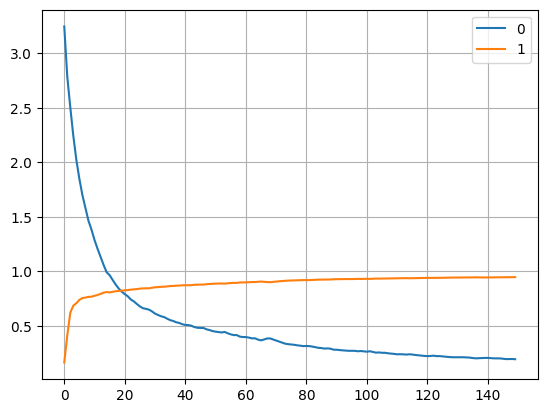

In [106]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

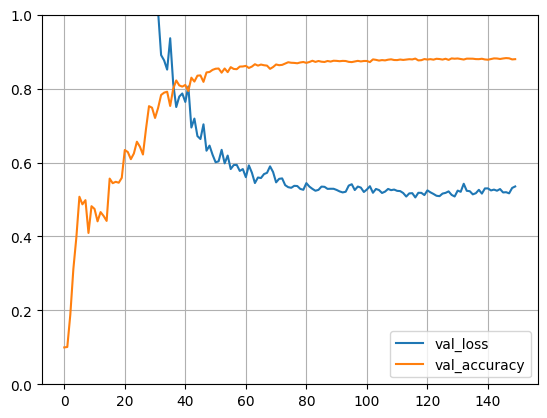

In [107]:
plt.plot(retVal.history['val_loss'], label = 'val_loss')
plt.plot(retVal.history['val_accuracy'], label = 'val_accuracy')
plt.ylim((0,1))
plt.legend()
plt.grid(True)

In [151]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img[0:16])
    
    predictions_softmax = model.predict(imgProc)
    predictions = np.empty((16,256,256,3))
    
    for k in range(16) :
        for i in range(256) :
            for j in range(256) :
                predictions[k][i][j] = labeltoRGB(rgb_dict,predictions_softmax[k][i][j].argmax())
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask.astype('int64'))
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')
    
    
    
    

In [140]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, myTransformer)

1/1 [==============================] - 0s 41ms/step


In [152]:
sixteenPrediction[1][0][100]

array([128., 128., 128.])

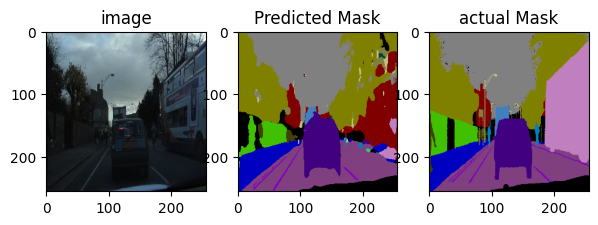

In [153]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])

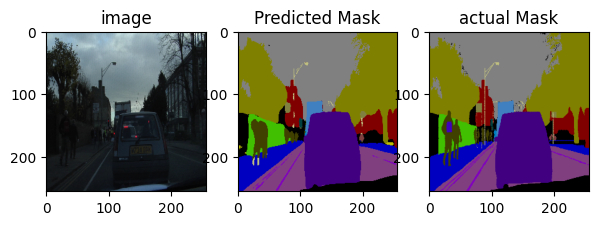

In [154]:
Plotter(actuals[2], sixteenPrediction[2], masks[2])

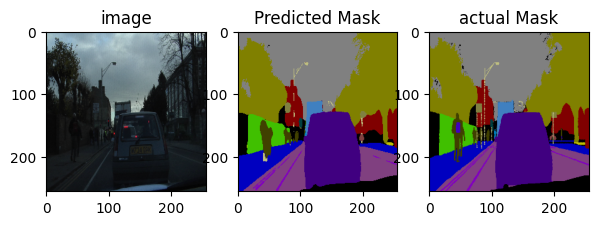

In [155]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

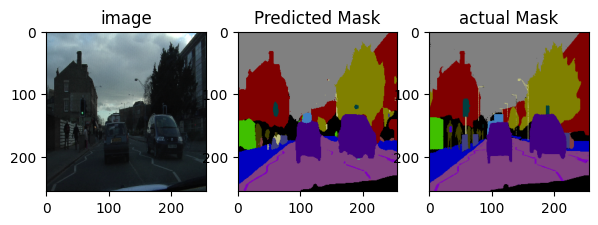

In [156]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

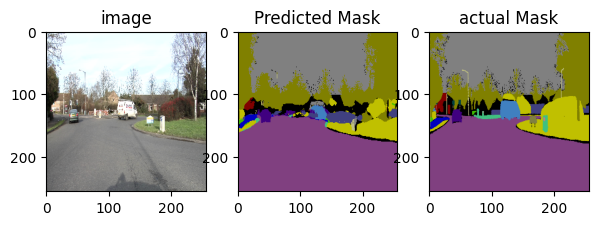

In [157]:
Plotter(actuals[9], sixteenPrediction[9], masks[9])

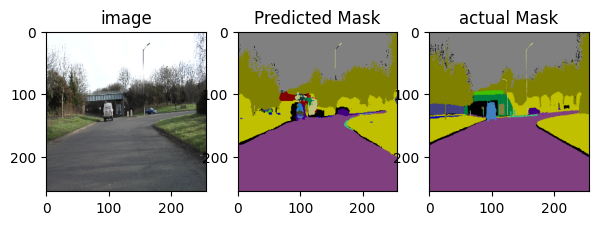

In [158]:
Plotter(actuals[11], sixteenPrediction[11], masks[11])

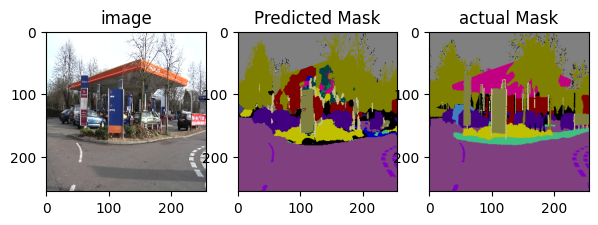

In [159]:
Plotter(actuals[14], sixteenPrediction[14], masks[14])

## prediction and IOU score

In [9]:
from tensorflow import keras
model = tf.keras.models.load_model('Unet_softmax')


In [10]:
#for metric evaluation
def predictAll (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    #mask = mask[0:16]
    
    #imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions_softmax = model.predict(imgProc)
    predictions = np.empty((100,256,256,1))
    
    for k in range(100) :
        for i in range(256) :
            for j in range(256) :
                predictions[k][i][j] = predictions_softmax[k][i][j].argmax()
    
    
    return predictions, imgProc, mask
    

In [11]:
Prediction, actuals, masks = predictAll(framObjValidation, model)


4/4 [==============================] - 6s 189ms/step


In [12]:
#get label for all pixels

predicted_label_list = []
true_label_list = []
for k in range(100) : #img #
    for i in range(256) : 
        for j in range(256) : #get rgb pixels
            predicted_label_list.append(int(Prediction[k][i][j][0]))
            true_label_list.append(RGBtolabel(masks[k][i][j]*255,label))



In [13]:
from sklearn import metrics
from sklearn.metrics import classification_report
y_true = true_label_list
y_pred = predicted_label_list



In [14]:
iou_score_list = []
for i in range(32) :
    m = tf.keras.metrics.IoU(num_classes=32, target_class_ids=[i])
    m.update_state(y_pred=y_pred,y_true=y_true)
    iou_score_list.append( m.result().numpy())


In [15]:
class_name = pd.read_csv('CamVid/class_dict.csv',usecols=[0])
class_name

,name
0,Animal
1,Archway
2,Bicyclist
3,Bridge
4,Building
5,Car
6,CartLuggagePram
7,Child
8,Column_Pole
9,Fence


In [16]:
iou_score_list

[0.0,
 0.0,
 0.560064,
 0.0,
 0.8533841,
 0.74923885,
 0.0,
 0.0,
 0.13654801,
 0.44652197,
 0.6094292,
 0.0,
 0.19434777,
 0.0,
 0.22132863,
 0.274076,
 0.18920112,
 0.9327647,
 0.45493093,
 0.81198657,
 0.15471655,
 0.92651814,
 0.30208442,
 0.0,
 0.38774243,
 0.0,
 0.756708,
 0.22319847,
 0.0,
 0.53375787,
 0.26741928,
 0.56867826]

In [17]:
class_name['iou_score'] = iou_score_list

In [18]:
class_name.to_excel('iou_score_unet_softmax.xlsx')

## classification report

In [19]:
class_report = classification_report(y_true=y_true,y_pred=y_pred)

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [20]:
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8124
           1       0.00      0.00      0.00     14534
           2       0.75      0.69      0.72     31137
           3       0.00      0.00      0.00      1791
           4       0.90      0.95      0.92   1461737
           5       0.82      0.89      0.86    237769
           6       0.00      0.00      0.00      4592
           7       0.00      0.00      0.00      4554
           8       0.41      0.17      0.24     58681
           9       0.74      0.53      0.62     86465
          10       0.74      0.78      0.76    111325
          11       0.00      0.00      0.00      3231
          12       0.49      0.24      0.33     55250
          13       0.00      0.00      0.00       398
          14       0.33      0.40      0.36     33600
          15       0.62      0.33      0.43     15710
          16       0.40      0.26      0.32     50326
          17       0.96    